## Cell Fate Decision Generative Model

In [2]:
import numpy as np
import scipy as sp
import emcee
import seaborn as sb
import matplotlib

The form of our data: 

After processing, we obtain number density fractions of difference cell types. These are as follows:

$n_b$=number density of pluripotent cells (both markers) per unit area (# 'both' cells in box)

$n_r$=density of red cells (Oct4) (# 'red' cells in box)

$n_g$=density of green cells (Sox2) (# 'green' cells in box)

Between two time steps, we assert the following: 

$$\Delta n_b= n_{entering, b} - n_{leaving, b} + n_{dividing, b} -n_{b\rightarrow g } - n_{g\rightarrow b}$$

Where $n_{entering, b}$ denotes the number of pluripotent cells entering the ROI, $n_{leaving, b}$ denotes the number exiting the ROI, $n_{dividing,b}$ denotes the number of pluripotent cells in the ROI that divide, $n_{b\rightarrow g } $ the number of cells that differentiate to green, and $n_{g\rightarrow b}$ the number of cells that differentiate to blue. 

$$\Delta n_g= n_{entering, g} - n_{leaving, g} + n_{dividing, g} +n_{b\rightarrow g } $$

Where $n_{entering, g}$ denotes the number of green cells entering the ROI, $n_{leaving, g}$ denotes the number exiting the ROI, and $n_{dividing,g}$ denotes the number of green cells in the ROI that divide.  

$$\Delta n_r= n_{entering, r} - n_{leaving, r} + n_{dividing, r} +n_{b\rightarrow r } $$

With variables defined as above. 

We can then convert these to differential equations (modulo some scaling factor):


$$ \frac{d n_b (t,x)}{dt}  = k_{entry}n_b(t,x_{neighbors})+(k_{division}-k_{departure}) n_b(t,x) - (k_{b\rightarrow g } + k_{b \rightarrow r})n_{b}(t,x) $$

$$ \frac{d n_g (t,x)}{dt} = k_{entry}n_g(t,x_{neighbors})+(k_{division}-k_{departure}) n_g(t,x) + k_{b\rightarrow g } n_{b}(t,x) $$

$$ \frac{d n_r (t,x)}{dt} = k_{entry}n_r(t,x_{neighbors})+(k_{division}-k_{departure}) n_r(t,x) + k_{b\rightarrow r } n_{b}(t,x) $$

Once we include noise, numerically solving this set of differential equations should recapitulate our data. To simplify analysis, we may choose to approximate $x_{neighbors}$ by $x$ because we expect density to vary slowly over the scale of a small number of analysis areas. Additionally, we have assumed above that $k_division$ is the same for all three cell types, as well as rates of motion. This should hold because these cell types are very similar, and are not readily distinguishable without these tags. 

The rates $k$ above are the average rates; in practice, the number densities will be non-deterministic due to various sources of error including: 

- errors due to cell counting algorithm (stochasticity from the observation)
    - To process our data set, we use a black-box cell counting software from MIT's Broad Institute. While this software is very good, it is still not perfect (and is also not as good as the naked eye). It will make errors due to issues such as image quality and resolution (blurring cell outlines), a wide spread of cell sizes (this type of segmentation algorithm usually does better when cells are relatively uniform in size), and possible overlap between cells. Because this is a mixture of many types of uncertainties, each of which has an unknown distribution. A gaussian is the most conservative way of estimating error, so we will treat these errors as gaussian with a single, non-time-varying $\sigma$ and mean 0. To determine the value of $\sigma_{obs}$ we will manually count the cells in a small subset of our images, then compare our counts against the actual count to determine the error of the computer algorithm. 
    
- stochasticity of cell behavior
    - Biological systems have a lot of inherent noise, and, to put it tritely, every rule will have exceptions. Some fraction of cells, even in a perfectly observed system, will not have the state that the model predicts. Additionally, the overall biological noise will act as a second gaussian modifying these densities (with mean 0, standard deviation $\sigma_{cells}$). While we can use literature or visual inspection of images to find a prior for this, it is something we will most likely have to marginalize over.  ##Seung Hwan will write
    
    - 
    
    - In this particular case, researchers have observed that the Sox2 reporter is unstable--some cells will silence their fluorescently tagged Sox2 while maintaining their untagged copy.  We expect this $k_{silence}$ to be significantly smaller than the other values, but we should nonetheless include it.
    
$$ \frac{d n_b^* (t,x)}{dt} = \frac{d n_b (t,x)}{dt}-k_{silence}  n_b(t,x) $$ 
$$ \frac{d n_g^* (t,x)}{dt} = \frac{d n_g (t,x)}{dt}-k_{silence} n_g(t,x) $$
$$ \frac{d n_r^* (t,x)}{dt} = \frac{d n_r (t,x)}{dt}+k_{silence} n_b(t,x) $$

        



Let $\vec{n} = (n_b,n_g,n_r)$ (evaluated at any (x,t). Let $\vec{k}$ denote the parameter vector for rates $(k_{entry}, k_{departure}, k_{division}, k_{b \rightarrow g}, k_{b \rightarrow r}, k_{silence})$. We will numerically solve the above system to find $m(\vec{n}|\vec{k})$. Let $\vec{e }$ denote the gaussian observation error in $\vec{n}$ and let $\vec{\epsilon}$ denote the gaussian measurement observation error in $\vec{n}$ (as described in Gregory 4.8.2).

Then the prediction $\vec{\mathfrak{n}}$ from our generative model is:

$$\vec{z} = m(\vec{\mathfrak{n}}|\vec{k}) + \vec{e_i} + \vec{\epsilon_i}$$

We can then show, as Gregory equation 4.5:

$$p ( N| M, \vec{k},I) =\frac{1}{\sqrt{2 \pi (\sigma^2_{obs}+\sigma^2_{cells}}) } \exp \{ \frac{-(\vec{N}-\vec{m}(\vec{n}|\vec{k}))^2}{2(\sigma_{obs}^2+\sigma_{cells}^2)} \}$$

(Gregory 4.51 essentially)

Next we need to get from a single point in (x,t) to the full three dimensions (x,y,t) of our data. We assume that observational noise is independent (so will be separable). Noise inherent to our system is the sum of noise from many biological processes on different time-scales. We will assume this noise is independent our data points can still be treated as independent. We thus can multiply the likelihood of each data point to get the final likelihood function for our generative model. Let $T$ by the total number of time steps and $B$ be the total number of bins per time step.

$$p(D|M, \vec{k},I)=(2\pi)^{-B T /2} \{ \prod_{i=1}^T\prod_{j=1}^{B} (\sigma_{obs}^2 +\sigma_{cells}^2)^{-1/2} \} \exp \{ \sum_{i,j=1}^{i=T,j=B} (\frac{-(\vec{n_{i,j}}-\vec{m}(\vec{n_{i,j}}|\vec{k}))^2}{2(\sigma_{obs}^2+\sigma_{cells}^2)} ) \}$$

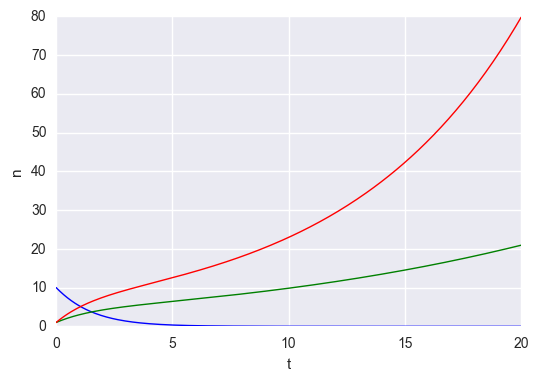

In [3]:
# Numerical solver of the differential equation
# Reference: http://scipy-cookbook.readthedocs.io/items/CoupledSpringMassSystem.html

% matplotlib inline

import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.integrate import odeint

def vectorfield(w, t, p):
    """
    Defines the differential equations for the coupled spring-mass system.

    Arguments:
        w :  vector of the state variables:
                  w = [b,r,g]
        t :  time
        p :  vector of the parameters:
                  p = [k_ent,k_div,k_dep,k_bg,k_br]
    """
    b, r, g = w
    k_ent, k_div, k_dep, k_bg, k_br = p
    N = b+r+g
    ratio_b, ratio_r, ratio_g = b/N, r/N, g/N

    # Create f = (b',r',g'):
    f = [ratio_b*k_ent*b + (k_div - ratio_b*k_dep)*b - (k_bg+k_br)*b,
         ratio_r*k_ent*r + (k_div - ratio_r*k_dep)*r + k_br*b,
         ratio_g*k_ent*g + (k_div - ratio_g*k_dep)*g + k_bg*b,]
    return f

# Parameter values
k_ent = 0.2
k_div = 0.05
k_dep = 0.1
k_bg = 0.25
k_br = 0.5

# Initial conditions
b = 10
r = 1
g = 1

# ODE solver parameters
stoptime = 20.0
numpoints = 250

# Create the time samples for the output of the ODE solver.
t = np.linspace(0, stoptime, numpoints)

# Pack up the parameters and initial conditions:
p = [k_ent, k_div, k_dep, k_bg, k_br]
w0 = [b, r, g]

# Call the ODE solver.
wsol = odeint(vectorfield, w0, t, args=(p,))

#Plot the solution that was generated
b = wsol[:,0] 
r = wsol[:,1] 
g = wsol[:,2] 

plt.xlabel('t')
plt.ylabel('n')
lw = 1

plt.plot(t, b, 'b', linewidth=lw)
plt.plot(t, g, 'g', linewidth=lw)
plt.plot(t, r, 'r', linewidth=lw)

In [ ]:
sajdlfjlksjflasjlkdfjaslkdfjlsakjflksdjlkasfjalksjksfldj